In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydataset import data
import statistics
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy
import acquire
import prepare
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
# importing my personal wrangle module
import wrangle
import feature_engineering

In [2]:
swiss = data('swiss')
swiss.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [3]:
# SPLIT....which is throwing errors rn.  Will return.


#Test set is .2 of original dataframe
train, test = train_test_split(swiss, test_size = .2, random_state=123) # you can't stratify on a continuous!, stratify= tips.tip)
# The remainder is here divided .7 to train and .3 to validate
train, validate = train_test_split(train, test_size=.3, random_state=123)
train.shape,validate.shape,test.shape

((25, 6), (12, 6), (10, 6))

In [4]:
X_train = train.drop(columns=['Fertility'])
y_train = pd.DataFrame(train.Fertility, columns=['Fertility'])

X_validate = validate.drop(columns=['Fertility'])
y_validate = pd.DataFrame(validate.Fertility, columns=['Fertility'])

X_test = test.drop(columns=['Fertility'])
y_test = pd.DataFrame(test.Fertility, columns=['Fertility'])

X_train.shape,y_train.shape,X_validate.shape,y_validate.shape,X_test.shape,y_test.shape,



((25, 5), (25, 1), (12, 5), (12, 1), (10, 5), (10, 1))

In [5]:
swiss.columns

Index(['Fertility', 'Agriculture', 'Examination', 'Education', 'Catholic',
       'Infant.Mortality'],
      dtype='object')

In [6]:
# Scale here....

scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = ['Agriculture', 'Examination', 'Education', 'Catholic', 'Infant.Mortality'])
X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), columns = ['Agriculture', 'Examination', 'Education', 'Catholic', 'Infant.Mortality'])
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = ['Agriculture', 'Examination', 'Education', 'Catholic', 'Infant.Mortality'])

In [7]:
feature_engineering.select_kbest(X_train_scaled, y_train,3)

['Examination', 'Catholic', 'Infant.Mortality']

In [8]:
feature_engineering.select_rfe(X_train_scaled, y_train, 3)

['Agriculture', 'Examination', 'Infant.Mortality']

wow. just wow. 

In [9]:
# show_features_rankings(X_train_scaled, rfe)
# need to define rfe in the notebook if i want to use ryan's function here

# Modeling:

In [10]:
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

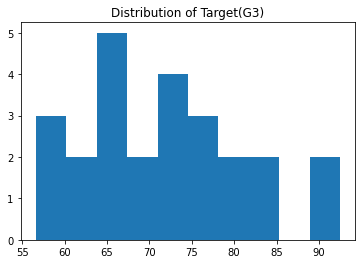

In [11]:
# how do we determine distribution?
plt.hist(y_train)
plt.title('Distribution of Target(G3)')
plt.show()

### Baseline

In [12]:
# 1. Predict G3_pred_mean
Fertility_pred_mean = y_train.Fertility.mean()
y_train['Fert_pred_mean'] = Fertility_pred_mean
y_validate['Fert_pred_mean'] = Fertility_pred_mean

In [13]:
# 2. compute G3_pred_median
Fertility_pred_median = y_train.Fertility.median()
y_train['Fert_pred_median'] = Fertility_pred_median
y_validate['Fert_pred_median'] = Fertility_pred_median

In [14]:
y_train.head()

,Fertility,Fert_pred_mean,Fert_pred_median
Rolle,60.5,71.536,71.7
Lavaux,65.1,71.536,71.7
Nyone,56.6,71.536,71.7
Conthey,75.5,71.536,71.7
Yverdon,65.4,71.536,71.7


In [15]:
# 3. RMSE of G3_pred_mean
rmse_train = mean_squared_error(y_train.Fertility,
                                y_train.Fert_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.Fert_pred_mean) ** (0.5)

In [16]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  9.77 
Validate/Out-of-Sample:  14.78


In [17]:
# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(y_train.Fertility, y_train.Fert_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.Fert_pred_median) ** (0.5)
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  9.78 
Validate/Out-of-Sample:  14.83


In [18]:
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])

In [19]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,9.775091,14.825063


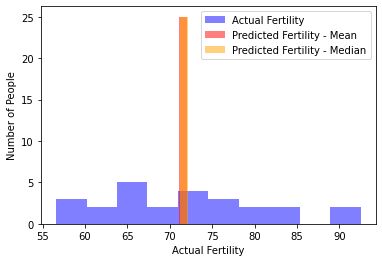

In [20]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.Fertility, color='blue', alpha=.5, label="Actual Fertility")
plt.hist(y_train.Fert_pred_mean, bins=1, color='red', alpha=.5,  label="Predicted Fertility - Mean")
plt.hist(y_train.Fert_pred_median, bins=1, color='orange', alpha=.5, label="Predicted Fertility - Median")
plt.xlabel("Actual Fertility")
plt.ylabel("Number of People")
plt.legend()
plt.show()

### OLS Model

In [21]:
# create the model object

lm = LinearRegression()

In [22]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 

# 
lm.fit(X_train, y_train.Fertility)

LinearRegression()

In [23]:
# predict train
# 

y_train['Fert_pred_lm'] = lm.predict(X_train)

y_train.head()

,Fertility,Fert_pred_mean,Fert_pred_median,Fert_pred_lm
Rolle,60.5,71.536,71.7,60.269929
Lavaux,65.1,71.536,71.7,62.787338
Nyone,56.6,71.536,71.7,58.254874
Conthey,75.5,71.536,71.7,73.350724
Yverdon,65.4,71.536,71.7,75.224245


In [24]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.Fertility, y_train.Fert_pred_lm) ** .5
# predict validate
y_validate['Fert_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.Fert_pred_lm) ** (0.5)


print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  4.571043042889269 
Validation/Out-of-Sample:  12.132738217927676


In [25]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [26]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,9.775091,14.825063
1,OLS Regressor,4.571043,12.132738


### LassoLars

In [27]:
# a good balance is a low rmse and a low difference

lars = LassoLars(alpha= .1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.Fertility)

# predict train
y_train['Fert_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Fertility, y_train.Fert_pred_lars) ** (1/2)

# predict validate
y_validate['Fert_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.Fert_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nDifference: ", rmse_validate - rmse_train)

RMSE for Lasso + Lars
Training/In-Sample:  4.819362360890851 
Validation/Out-of-Sample:  12.85754085257906 
Difference:  8.038178491688209


In [28]:
metric_df = metric_df.append({
    'model': 'lasso_alpha0.01', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,9.775091,14.825063
1,OLS Regressor,4.571043,12.132738
2,lasso_alpha0.01,4.819362,12.857541


### TweedieRegressor (GLM)

In [29]:
from sklearn.linear_model import TweedieRegressor

In [30]:
# as seen in curriculum, the power ought to be set per distribution type
# power = 0 is same as OLS

glm = TweedieRegressor(power=1.5, alpha=2)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.Fertility)

# predict train
y_train['Fert_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Fertility, y_train.Fert_pred_glm) ** (1/2)

# predict validate
y_validate['Fert_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.Fert_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1.5 & alpha=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1.5 & alpha=2
Training/In-Sample:  4.48695773388851 
Validation/Out-of-Sample:  12.167539655938667


In [31]:
metric_df = metric_df.append({
    'model': 'glm_poisson', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,9.775091,14.825063
1,OLS Regressor,4.571043,12.132738
2,lasso_alpha0.01,4.819362,12.857541
3,glm_poisson,4.486958,12.167540


### Polynomial Regression

In [32]:
# make the polynomial features to get a new set of features. import from sklearn
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

### Linear Regression

In [33]:
# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.Fertility)

# predict train
y_train['Fert_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Fertility, y_train.Fert_pred_lm2) ** (1/2)

# predict validate
y_validate['Fert_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.Fert_pred_lm2) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  2.5893942606683105 
Validation/Out-of-Sample:  26.657466827361734


In [34]:
metric_df = metric_df.append({
    'model': 'quadratic', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,9.775091,14.825063
1,OLS Regressor,4.571043,12.132738
2,lasso_alpha0.01,4.819362,12.857541
3,glm_poisson,4.486958,12.167540
4,quadratic,2.589394,26.657467


## Evaluation

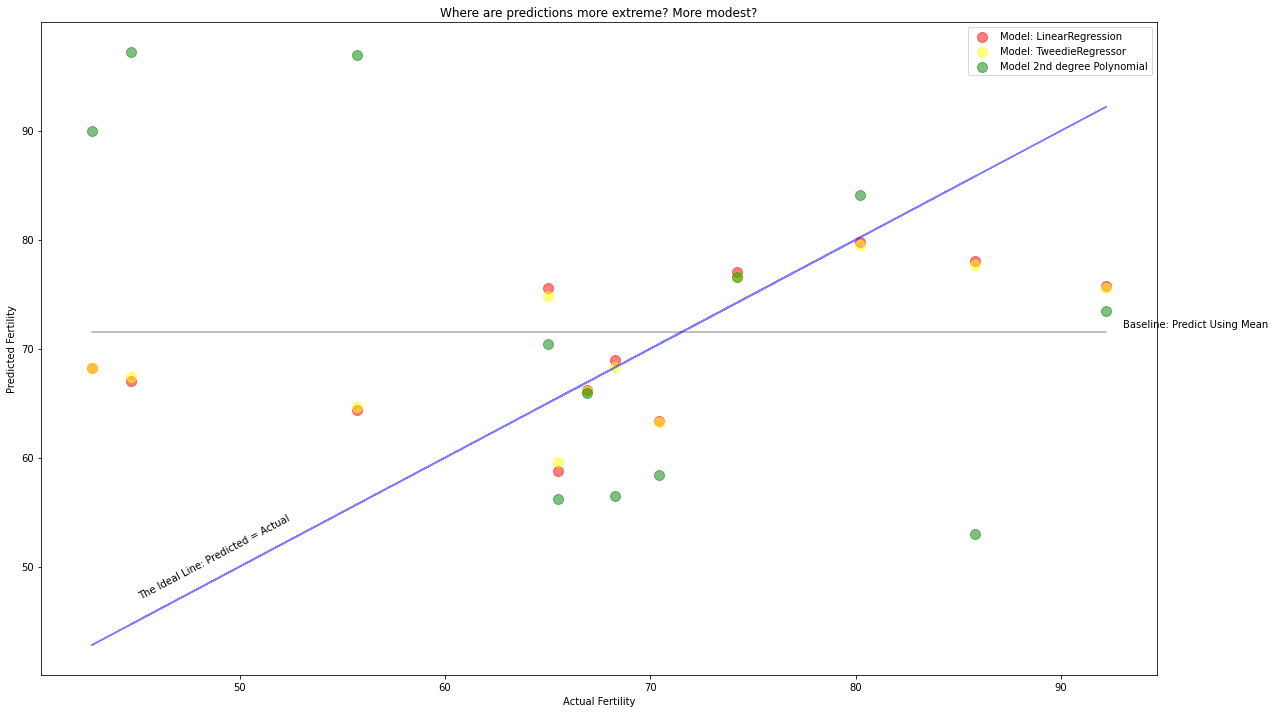

In [35]:
# y_validate.head()
plt.figure(figsize=(20,12))
plt.plot(y_validate.Fertility, y_validate.Fert_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (93, 72))
plt.plot(y_validate.Fertility, y_validate.Fertility, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (45,47), rotation=28)

plt.scatter(y_validate.Fertility, y_validate.Fert_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.Fertility, y_validate.Fert_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.Fertility, y_validate.Fert_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Fertility")
plt.ylabel("Predicted Fertility")
plt.title("Where are predictions more extreme? More modest?")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

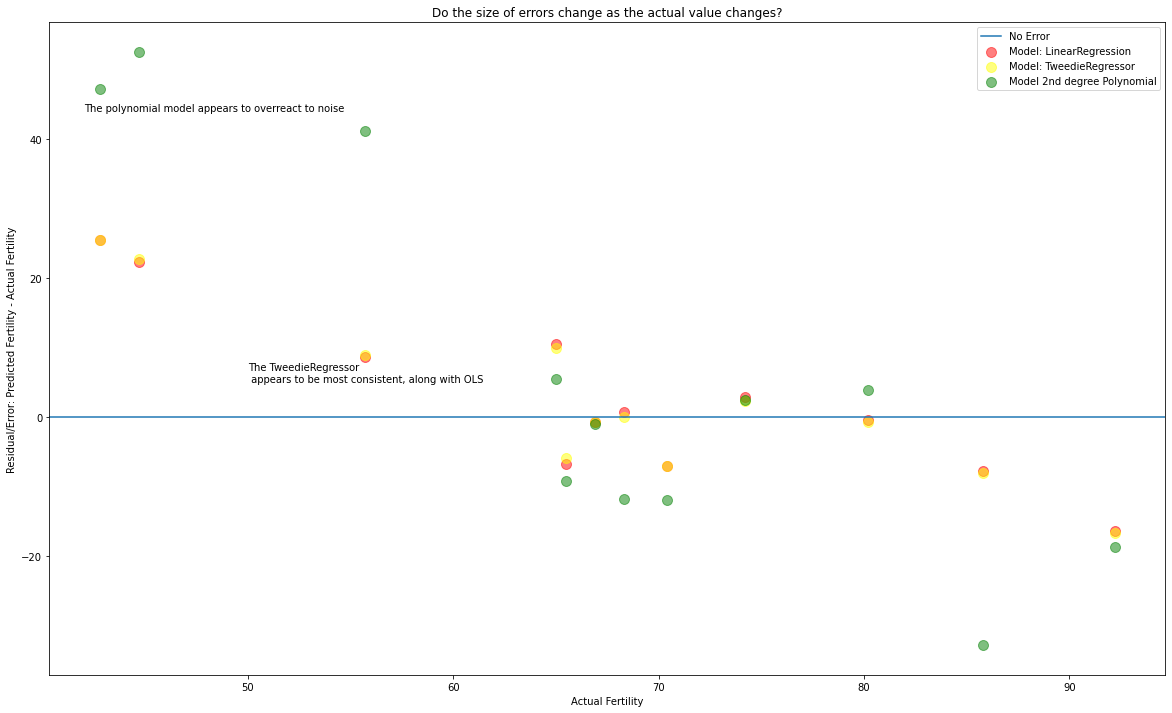

In [36]:
plt.figure(figsize=(20,12))
plt.axhline(label="No Error")
plt.scatter(y_validate.Fertility, y_validate.Fert_pred_lm - y_validate.Fertility , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.Fertility, y_validate.Fert_pred_glm - y_validate.Fertility, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.Fertility, y_validate.Fert_pred_lm2 - y_validate.Fertility, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Fertility")
plt.ylabel("Residual/Error: Predicted Fertility - Actual Fertility")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (42,44))
plt.annotate("The TweedieRegressor\n appears to be most consistent, along with OLS", (50,5))
plt.show()

In [37]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,9.775091,14.825063
1,OLS Regressor,4.571043,12.132738
2,lasso_alpha0.01,4.819362,12.857541
3,glm_poisson,4.486958,12.167540
4,quadratic,2.589394,26.657467


In [38]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['Fert_pred_glm'] = glm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.Fertility, y_test.Fert_pred_glm) ** (1/2)

print("RMSE for GLM Model using TweedieRegressor\nOut-of-Sample Performance: ", rmse_test)

RMSE for GLM Model using TweedieRegressor
Out-of-Sample Performance:  11.5297805722039


## Wow, the model did not beat the train baseline on the test data : (
- But it did beat if versus the validate data...

In [39]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['Fert_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.Fertility, y_test.Fert_pred_lm) ** (1/2)

print("RMSE for OLS Model\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model
Out-of-Sample Performance:  10.679921011236853


## OLS did better : /